**How to use this Notebook:** If you're new to iPython, Jupyter Notebooks, and Binder, a few comments may be helpful here... The file you're looking at was written as a combination of Python, Markdown, LaTeX, and is saved as something called an iPython Notebook (.ipynb). If you're seeing this page, you followed a link I gave you and clicked on the associated .ipynb. The Notebook format is the brainchild of Project Jupyter, and the Binder project lets you view Notebooks interactively using a tiny chunk of free server space you had allocated to you when you opened this file. Binder is what makes this experience interactive (thank you Binder!). As you follow along, you'll see results pre-populated from the last time I ran this before I posted it online. You can run your own experiments by clicking on each line of code (one by one, starting from the top), then clicking the Run button near the top of the page. There are some really nice people out there paying for our ability to use this server space for free, so please be kind and close this page as soon as you're not actively looking at it (this frees up the resources to other Binder users) - you can always come back and run this again! The open source community thanks you =)

# PiBlocks shows a fun way to compute digits of $\pi$ by counting collisions

## Even if you've heard of this idea before, check out this video!

3Blue1Brown has an excellent YouTube video about [The Most Unexpected Answer to a Counting Puzzle](https://www.youtube.com/watch?v=HEfHFsfGXjs)

He even posted a few follow-up videos on his channel showing mathematical proofs for this problem.

## Let's pin down our notation

Given the definitions in the artistic masterpiece below, the problem statement goes something like this:

Find two blocks with masses $m_1$ and $m_2$, where $m_2$ is any power of $100$ times more massive than $m_1$, and place them in in a scenario with frictionless surfaces and perfectly elastic conditions with $m_1$ nearer to the wall than $m_2$. If you push $m_2$ towards $m_1$ at any initial velocity, the number of collisions that occur thereafter will approximately equal $\pi$. Amazingly, you can theoretically use this method to approximate $\pi$ to any accuracy by increasing the mass of $m_2$ by factors of $100$. More formally, $\frac{m_2}{m_1}=100^{k-1}, k\in {\mathbb{N}}_1$.


`.                                                                                                  .`<br>
`.  (WALL)            (ALL COLLISIONS IN THIS PROBLEM ARE PERFECTLY ELASTIC)                        .`<br>
`.   \\|                                                                                            .`<br>
`.   \\|                                _________________                                           .`<br>
`.   \\|                 v2(0)<0       |                 |                                          .`<br>
`.   \\|       (initial velocity of m2)|                 |                                          .`<br>
`.   \\|                      <--------|            (k-1)|   k is in the set {1, 2, 3, ... }        .`<br>
`.   \\|       ______                  | m2 = m1*100     |                                          .`<br>
`.   \\|      |      |                 |                 |                                          .`<br>
`.   \\|      |  m1  |                 |                 |                                          .`<br>
`.   \\|______|______|_________________|_________________|____________________                      .`<br>
`.                                                                         (FRICTIONLESS FLOOR)     .`<br>
`.                                                                                                  .`<br>
`.   -------------------------------------------------------------------->                          .`<br>
`.   x=0                                                                 x increasing               .`<br>
`.                                                                                                  .`<br>

## Let's simulate this first (and prove it with math later)

To make this simulation as simple as possible, for this particular problem we can write an update equation where the velocities of Mass 1 and Mass 2 after a collision depend only on their masses and their velocities just prior to the collision. Since the floor is frictionless, the velocities will be the same until the next collision (no matter how long it takes). **This means we only need to model the collision dynamics, independent of (absolute) time!** 

***(Step 1)*** First, we'll need a few tools from numpy.

In [1]:
from numpy import array, matmul

**(Step 2)** Next, we want to select a $k$ for this experiment (which is identical to specifying how many digits of $\pi$ we want to calculate)

#### Note: this simulation has exponential time complexity $O(10^k)$ (the number of times the loop runs increases by a factor of $10$ each time you increment $k$ by $1$). 
#### Translation: Keep $k$ between $1$ and $7$ so as not to inadvertently break anything.

In [2]:
k = 3

**(Step 3)** Now let's set the masses and velocities $m_1, m_2, v_1, v_2$. I set $m_1$ to have unit mass, so $m_2$ is just $100^{k-1}$ (Python uses \*\* as the exponent operator). Mass 1 has an initial velocity of $0$. Leftward motion corresponds to negative velocity (while rightward means positive). The resulting number of collisions turns out to be invariant to the initial velocity of Mass 2 (as long as it is negative). I initialized it with unit negative velocity, but feel free to experiment with this idea.

In [3]:
v1, v2, m1, m2 = 0, -1, 1, 100**(k-1)

**(Step 4)** Now we're going to work directly from [fundamental physics equations for elastic collisions](https://en.wikipedia.org/wiki/Elastic_collision#One-dimensional_Newtonian). You'll find these equations on Wikipedia. Let's reformulate these equations using matrices. The $A$ matrix models the collisions, and the $B$ matrix corresponds to Mass 1 bouncing off the wall (since it simply reflects the velocity of Mass 1 from negative to positive).

$A = \begin{bmatrix}\frac{m_1-m_2}{m_1+m_2}& \frac{2 m_2}{m_1+m_2}\\ \frac{2 m_1}{m_1+m_2}&\frac{m_2-m_1}{m_1+m_2}\end{bmatrix},  B = \begin{bmatrix}-1&0\\ 0&1\end{bmatrix}, v = \begin{bmatrix}v_1\\v_2\end{bmatrix}, u = \begin{bmatrix}u_1\\u_2\end{bmatrix}$

In [4]:
A = array([[(m1-m2),(2*m2)],[(2*m1),(m2-m1)]])/(m1+m2)
B = array([[-1,0],[0,1]])

**(Step 5)** There are no collisions at the outset of this experiment, so let's initialize the collisions counter to $0$.

In [5]:
collisions = 0

**(Step 6)** This step is wordy but I want to discuss the meat of the simulation line-by-line. What you'll see is a while loop, and the loop will keep running over and over again (incrementing the collisions counter by $+1$ each time) until the "exit conditions" are reached. The exit conditions simply state that Mass 1 and Mass 2 are both moving away from the wall, and Mass 2 must be moving at least as fast as Mass 1 so the masses themselves will never collide with each other or with the wall again. Additionally, because Mass 1 has an initial velocity of 0, and Mass 2 has some initial negative velocity, the first collision will always happen between Mass 2 and Mass 1 (so the $A$ matrix models the result of this collision as $v = Au$). You'll notice from the problem statement that Mass 1 and Mass 2 will never collide twice back-to-back. Because of this, after a Mass 1 Mass 2 collision, there will either be a collision with the wall or no collisions will ever happen again. Similarly, when Mass 1 will never collide with the wall twice in a row. After Mass 1 hits the wall (modeled as $v = Bu$), it will either collide with Mass 2 or no collisions will happen ever again. So we get this toggling action between the $A$ matrix and $B$ matrix. Very conveniently, the $A$ matrix models all odd numbered collisions, and the $B$ matrix models all even numbered collisions. The code selects this by using the modulo operation (%) which gives the remainder of an integer division (in our case, we mod by $2$, giving either $0$ or $1$ as the result which tells us whether we should model the next collision using the $A$ or $B$ matrix).

A few notes on the implementation: in Python, the first element of an array has index $0$. We originally implicitly defined $v_1, v_2$ as "number" types, which are scalars. In order to use our $A$ and $B$ matrices, we use the $array()$ function so that we can leverage matrix multiplication functionality with $matmul()$. After this, the results $v[0]$ and $v[1]$ have "array" types, but we want them to be scalars (so as not to break the code - the while loop expects scalar "number" types when evaluating the exit conditions). The $float()$ operator does something called "casting" where the array type is changed to a scalar "float" type. If you're unfamiliar with casting, the intuition behind it is fairly straightforward. A quick google search should clear this up if you're not comfortable with what's going on in the code below.

In [6]:
while not((v1>=0)&(v2>=0)&(v2>=v1)):
    v = array([[v1],[v2]])
    if (collisions%2)<1:
        v = matmul(A,v)
    else:
        v = matmul(B,v)
    v1, v2 = float(v[0]), float(v[1])
    collisions += 1

**(Step 7)** Now that the simulation is done, we just need to print the result. As expected, we get $k$ digits of pi. More specifically, $\pi \approx \frac{collisions}{10^{(k-1)}}$

In [7]:
print(collisions)

314


### We did it! The above line of code shows that digits of $\pi$ fall out of our simulation, which agrees with our expectations.

## That can be the end of tonight's show - if you want. However... we didn't *prove* anything (analytically). Fellow math nerds, please stay tuned.

The following section focuses less on code and more on visualization. I won't explain all of the plotting functionalities - just know that the large chunks of code are only used to get the plots to look exactly the way I wanted.

Let's inspect the Kinetic Energy (K.E.) equation $\frac{1}{2} m_1 v_1^2 + \frac{1}{2} m_2 v_2^2 = const.$

The K.E. equation implicitly defines an ellipse, but if you make the substitution $v_1 = \frac{(m_1)}{(2*C)}\tilde{v_1}$, $v_2 = \frac{(m_2)}{(2*C)}\tilde{v_2}$, something interesting happens...

This choice implies $\tilde{v_1}^2 + \tilde{v_2}^2 = 1$, which is the equation for the unit circle! *(foreshadowing intended)*

#### The following code is like a 'reset button' for our simulation. Run it at least once to get started.
#### (Don't worry about understanding the code just yet - work through the rest of the tutorial and read through it later if you want the nitty-gritty details!)

In [8]:
from numpy import absolute, arctan2, array, linspace, matmul, max, pi, sqrt
import matplotlib.pyplot as plt

class simulation(object):
    """
    This object is a container for our PiBlocks "universe".
    To initialize a simulation, you provide the number of digits of pi you want
    to calculate (which is the variable k), and (optionally) the initial 
    velocity v2 of mass m2.
    """
    def __init__(self, k, v2=-1):
        k = float(k)
        assert v2<0., "please make v2 less than (but not equal to) 0"
        assert (k).is_integer(), "please make k a whole number"
        assert (k>0), "please make k greater than equal to 1"
        self.collisions = 0
        self.k = k
        self.m1 = 1 # the previous code lets you see the ratio of masses is what matters
        self.m2 = 100**(k-1) # this code is simplified after setting m1 as the unit mass
        self.v1_initial = 0 # this starts off stationary
        self.v2_initial = v2
        self.A = array([[(self.m1-self.m2),(2*self.m2)],[(2*self.m1),(self.m2-self.m1)]])\
                 /(self.m1+self.m2)
        self.B = array([[-1,0],[0,1]])
        self.C = (1/2)*(self.m1)*(self.v1_initial)**2 + (1/2)*(self.m2)*(self.v2_initial)**2
        self.v = array([[self.v1_initial],[self.v2_initial]])
        self.v_tilde = (self.v)*array([[1/sqrt((2*self.C)/self.m1)],[1/sqrt((2*self.C)/self.m2)]])
        
        self.fig, self.axs = plt.subplots(1, 2, figsize=(18,12))
        
        # We'll need to keep track of the past three velocity pairs for both v and v_tilde.
        # We don't want to store data we don't need, so we'll create a list of length 3.
        # that behaves as first-in-last-out.
        self.v_memory = [array([[],[]]),array([[],[]]),array([[],[]])]
        self.v_tilde_memory = [array([[],[]]),array([[],[]]),array([[],[]])]
        self.v_memory.pop(0)
        self.v_tilde_memory.pop(0)
        self.v_memory.append(self.v)
        self.v_tilde_memory.append(self.v_tilde)
        
        # the below variables can stay in this private scope, we won't need to 
        # access the below variables in this frame again.
        epsilon = 10**(-10)
        v2_domain = sqrt(2*self.C/self.m2)*linspace(-1 + epsilon, 1 - epsilon, 180-1) 
        v2_tilde_domain = linspace(-1 + epsilon, 1 - epsilon, 180)
        v1_as_a_function_of_v2 = sqrt(2*self.C/self.m1 - (self.m2/self.m1)*v2_domain**2)
        v1_tilde_as_a_function_of_v2_tilde = sqrt(1 - (v2_tilde_domain)**2)
        
        # zorder is a property that lets you set what layers get plotted in what order
        self.zorder_axes = 0
        self.zorder_conservation_of_energy = 1
        self.zorder_annotations = 2
        self.zorder_step_sim = 3
        self.z_order_slope_between_last_two_points = 4
        self.zorder_adjacent_point_distance = 4
        self.zorder_adjacent_point_angle = 4
        self.zorder_plot_on_top_index = 0
        
        # we'll need to manipulate the figure object, so we'll store these 
        # initializations as data attributes of our simulation object
        self.axs[0].plot(v2_domain, v1_as_a_function_of_v2, 'b', zorder=self.zorder_conservation_of_energy)
        self.axs[0].plot(v2_domain, -v1_as_a_function_of_v2, 'b', zorder=self.zorder_conservation_of_energy)
        self.axs[0].set_title('v2, v1 plane', fontsize=10)
        self.axs[0].axis('equal')
        self.axs[0].arrow(0, 0, 1.25*v2_domain[-1], 0,\
                linewidth=0.5, color='k', zorder=self.zorder_axes)
        self.axs[0].arrow(0, 0, -1.25*v2_domain[-1], 0,\
                linewidth=0.5, color='k', zorder=self.zorder_axes)
        self.axs[0].arrow(0, 0, 0, 1.05*max(v1_as_a_function_of_v2),\
                linewidth=0.5, color='k', zorder=self.zorder_axes)
        self.axs[0].arrow(0, 0, 0, -1.05*max(v1_as_a_function_of_v2),\
                linewidth=0.5, color='k', zorder=self.zorder_axes)
        self.axs[0].annotate(" v2", xy=(1.3*v2_domain[-1], 0), zorder=self.zorder_annotations)
        self.axs[0].annotate("v1", xy=(0.5*max(v2_domain), 1.*max(v1_as_a_function_of_v2)), zorder=self.zorder_annotations)
        self.axs[0].axis(1.1*max(v1_as_a_function_of_v2)*array([-1,1,-1,1]))

        self.axs[1].plot(v2_tilde_domain,  v1_tilde_as_a_function_of_v2_tilde, 'b', zorder=self.zorder_conservation_of_energy)
        self.axs[1].plot(v2_tilde_domain, -v1_tilde_as_a_function_of_v2_tilde, 'b', zorder=self.zorder_conservation_of_energy)
        self.axs[1].set_title('v2_tilde, v1_tilde plane', fontsize=10)
        self.axs[1].axis('equal')
        self.axs[1].arrow(0, 0, 1.25*v2_tilde_domain[-1], 0,\
                linewidth=0.5, color='k', zorder=self.zorder_axes)
        self.axs[1].arrow(0, 0, -1.25*v2_tilde_domain[-1], 0,\
                linewidth=0.5, color='k', zorder=self.zorder_axes)
        self.axs[1].arrow(0, 0, 0, 1.25*max(v1_tilde_as_a_function_of_v2_tilde),\
                linewidth=0.5, color='k', zorder=self.zorder_axes)
        self.axs[1].arrow(0, 0, 0, -1.25*max(v1_tilde_as_a_function_of_v2_tilde),\
                linewidth=0.5, color='k', zorder=self.zorder_axes)
        self.axs[1].annotate("v2_tilde", xy=(1.1*v2_tilde_domain[-1], .1), zorder=self.zorder_annotations)
        self.axs[1].annotate("v1_tilde", xy=(0.15*max(v2_tilde_domain), 1.15*max(v1_tilde_as_a_function_of_v2_tilde)), zorder=self.zorder_annotations)
        self.axs[1].axis(2.5*max(v1_tilde_as_a_function_of_v2_tilde)*array([-1,1,-1,1]))


    def step_sim(self):
        """
        This function is meant to be run multiple times manually.
        If a simulation object is defined as:
            sim = simulation(2) # (for example)
        Then the simulation is stepped from one collision to the next with:
            sim.step_sim()
        And you can plot the results with:
            sim.fig
        """
        if not((self.v[0]>=0)&(self.v[1]>=0)&(self.v[1]>=self.v[0])):
            if (self.collisions%2)<1:
                self.v = matmul(self.A, self.v)
            else:
                self.v = matmul(self.B, self.v)
            self.v_tilde = (self.v)*array([[1/sqrt((2*self.C)/self.m1)],[1/sqrt((2*self.C)/self.m2)]])
            self.collisions += 1
            self.v_memory.pop(0)
            self.v_memory.append(self.v)
            self.v_tilde_memory.pop(0)
            self.v_tilde_memory.append(self.v_tilde)
        
        # here are a few more private scope variables that will also make the 
        # code easier to read. (x means horizontal axis and y means vertical).
        self.axs[0].plot(array([self.v_memory[2][1], self.v_memory[1][1]]),\
                         array([self.v_memory[2][0], self.v_memory[1][0]]),\
                         'ro--', markersize='11', zorder=self.zorder_step_sim)
        self.axs[1].plot(array([self.v_tilde_memory[2][1], self.v_tilde_memory[1][1]]),\
                         array([self.v_tilde_memory[2][0], self.v_tilde_memory[1][0]]),\
                         'ro--', markersize='11', zorder=self.zorder_step_sim)


    def adjacent_point_distance(self):
        self.axs[0].plot(array([self.v_memory[2][1], self.v_memory[0][1]]),\
                         array([self.v_memory[2][0], self.v_memory[0][0]]),\
                         'go-', markersize='11', linewidth = 5, zorder=self.zorder_adjacent_point_distance+self.zorder_plot_on_top_index)
        self.axs[1].plot(array([self.v_tilde_memory[2][1], self.v_tilde_memory[0][1]]),\
                         array([self.v_tilde_memory[2][0], self.v_tilde_memory[0][0]]),\
                         'go-', markersize='11', linewidth = 5, zorder=self.zorder_adjacent_point_distance+self.zorder_plot_on_top_index)
        self.zorder_plot_on_top_index+=1
        dist = sqrt((self.v_memory[2][0] - self.v_memory[0][0])**2 \
                     + (self.v_memory[2][1] - self.v_memory[0][1])**2)
        dist_tilde = sqrt((self.v_tilde_memory[2][0] - self.v_tilde_memory[0][0])**2 \
                     + (self.v_tilde_memory[2][1] - self.v_tilde_memory[0][1])**2)
        return dist, dist_tilde
    
    
    def adjacent_point_angle(self):
        self.axs[0].arrow(0, 0, float(self.v_memory[2][1]), float(self.v_memory[2][0]),\
                linewidth=5, color='g', zorder=self.zorder_adjacent_point_angle+self.zorder_plot_on_top_index)
        self.axs[0].arrow(0, 0, float(self.v_memory[0][1]), float(self.v_memory[0][0]),\
                linewidth=5, color='g', zorder=self.zorder_adjacent_point_angle+self.zorder_plot_on_top_index)
        self.axs[1].arrow(0, 0, float(self.v_tilde_memory[2][1]), float(self.v_tilde_memory[2][0]),\
                linewidth=5, color='g', zorder=self.zorder_adjacent_point_angle+self.zorder_plot_on_top_index)
        self.axs[1].arrow(0, 0, float(self.v_tilde_memory[0][1]), float(self.v_tilde_memory[0][0]),\
                linewidth=5, color='g', zorder=self.zorder_adjacent_point_angle+self.zorder_plot_on_top_index)
        self.zorder_plot_on_top_index+=1
        angle = absolute(arctan2(self.v_memory[2][1], self.v_memory[2][0]) - \
                 arctan2(self.v_memory[0][1], self.v_memory[0][0])) * 180 / pi
        angle_tilde = absolute(arctan2(self.v_tilde_memory[2][1], self.v_tilde_memory[2][0]) - \
                 arctan2(self.v_tilde_memory[0][1], self.v_tilde_memory[0][0])) * 180 / pi
        return angle, angle_tilde
    
    
    def slope_between_last_two_points(self):
        self.axs[0].plot(array([self.v_memory[2][1], self.v_memory[1][1]]),\
                         array([self.v_memory[2][0], self.v_memory[1][0]]),\
                         'bo-', markersize='11', linewidth = 5, zorder=self.z_order_slope_between_last_two_points+self.zorder_plot_on_top_index)
        self.axs[1].plot(array([self.v_tilde_memory[2][1], self.v_tilde_memory[1][1]]),\
                         array([self.v_tilde_memory[2][0], self.v_tilde_memory[1][0]]),\
                         'bo-', markersize='11', linewidth = 5, zorder=self.z_order_slope_between_last_two_points+self.zorder_plot_on_top_index)
        self.zorder_plot_on_top_index+=1
        if (self.collisions%2)<1:
            slope = "infinity"
            slope_tilde = "infinity"
        else:
            slope = str( (self.v_memory[2][0] - self.v_memory[1][0]) \
                       / (self.v_memory[2][1] - self.v_memory[1][1]))
            slope_tilde = str( (self.v_tilde_memory[2][0] - self.v_tilde_memory[1][0]) \
                             / (self.v_tilde_memory[2][1] - self.v_tilde_memory[1][1]))
        return slope, slope_tilde

### The last code block defined a type of container that keeps track of the salient aspects of our PiBlocks universe. Nothing happened just yet, but things will start to pick up when we instantiate a simulation in the next code block...

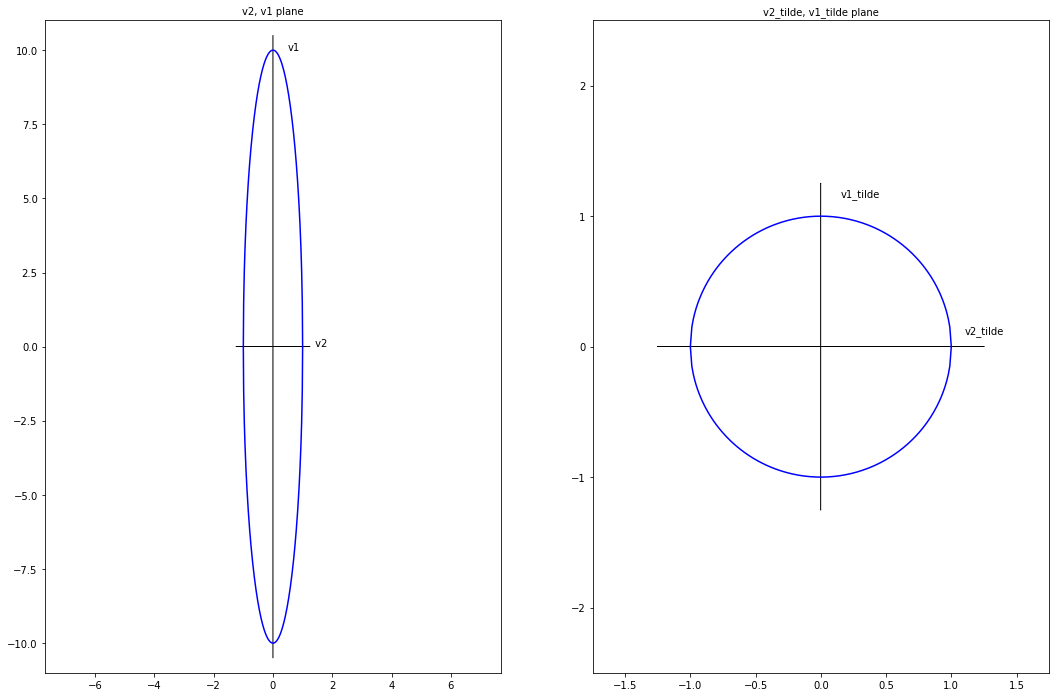

In [9]:
k = 2  # change k if you'd like

sim = simulation(k)

### Okay maybe circles and ellipses don't make it obvious where we're headed, but in the next code block things get much more interesting!

Let's re-formulate our simulation from earlier to model each collision one-by-one. We're going to see how $(v_2, v_1)$ (or equivalently $(\tilde{v}_2, \tilde{v}_1)$) update after each collision.

The collision model takes an ordered pair $(u_1, u_2)$ as an input and returns $(v_1, v_2)$ as an output. It makes sense to get an eye on how these points update from one collision to the next. If you run the below code block multiple times, you can watch the simulation evolve one collision at a time.

## The block below is the "main simulation". Run it a bunch of times. The helper functions in the code blocks that follow are intended to be run at any point in the middle of the simulation. Run any one of those and come back to this block! The simulation will stop updating when there are no more collisions.

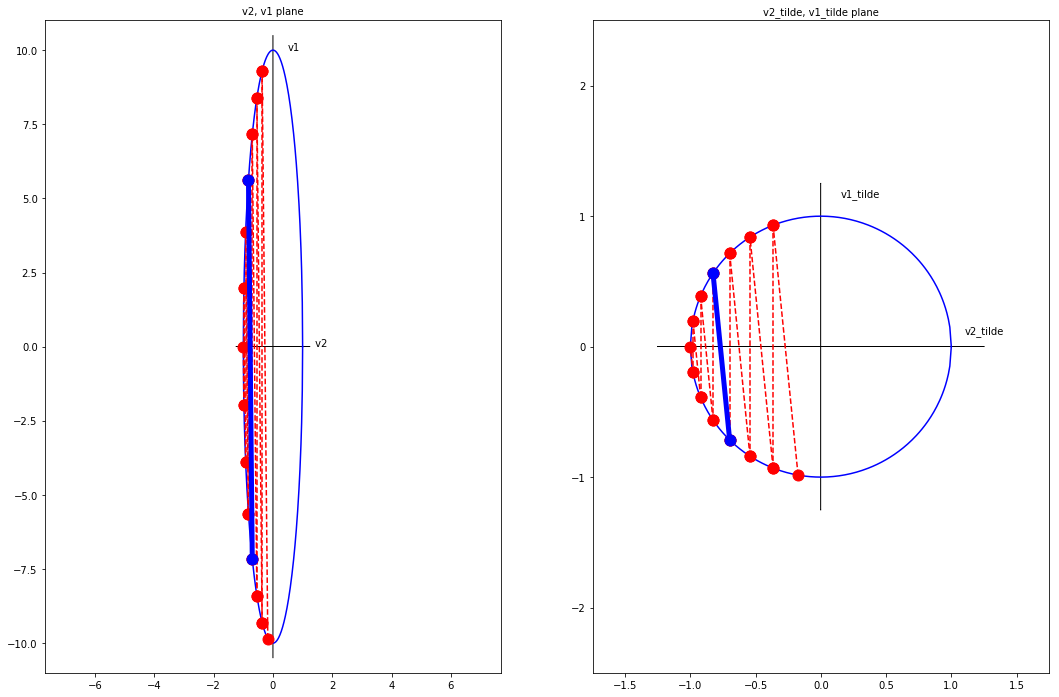

In [23]:
# run this block multiple times to see the effects on the plot
sim.step_sim()
sim.fig

### So maybe you've run the code block above so many times you lost track of the number of collisions. Run this next block at any point to see how many collisions we've got so far.

In [24]:
print("The current number of collisions = " + str(sim.collisions) + ". We set k = " + str(k) + \
      ", \nso we expect the number of collisions to stop increasing upon reaching the first " + str(k) + " digits of pi.")

The current number of collisions = 13. We set k = 2, 
so we expect the number of collisions to stop increasing upon reaching the first 2 digits of pi.


### If you look closely at the normalized (circular) plot on the right, you'll notice that the slope of every {odd, even} line is identical. If you look even more closely you might notice that the distance between adjacent dots is constant, and if you look really, really closely, you'll realize that means adjacent dots sweep the same angular distance with respect to the origin. All of these details are super important in the analytical proof for our "pi from collisions problem".
### But we can't just claim this without showing that it's true! It would be cruel to do that to you after we've come this far. This next helper function lets you calculate the slope defined by the two most recent points.

The slope of the last two points in (v2, v1) space is: [-100.]

The slope of the last two points in (v2_tilde, v1_tilde) space is: [-10.]


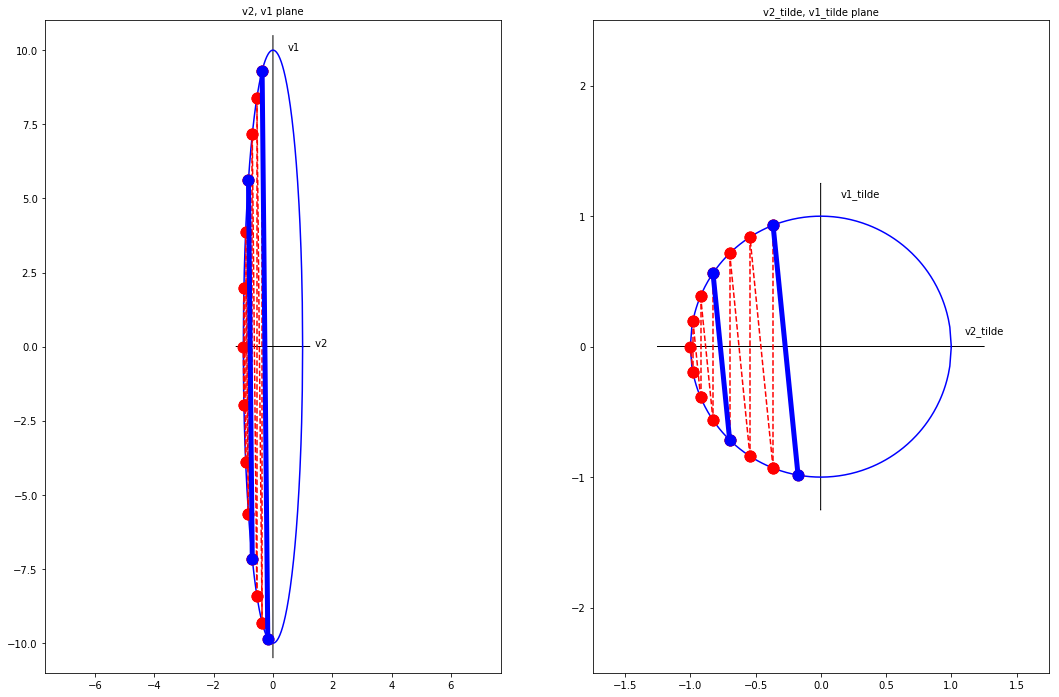

In [25]:
slope, slope_tilde = sim.slope_between_last_two_points()
print("The slope of the last two points in (v2, v1) space is: " + str(slope) + "\n\n"\
      "The slope of the last two points in (v2_tilde, v1_tilde) space is: " + str(slope_tilde))
sim.fig

### We can also take a look at the distance between two adjacent points using the next helper function...

The distance between the two most recent adjacent points in (v2, v1) space is: [0.57352171]

The distance between the two most recent adjacent points in (v2_tilde, v1_tilde) space is: [0.19900744]


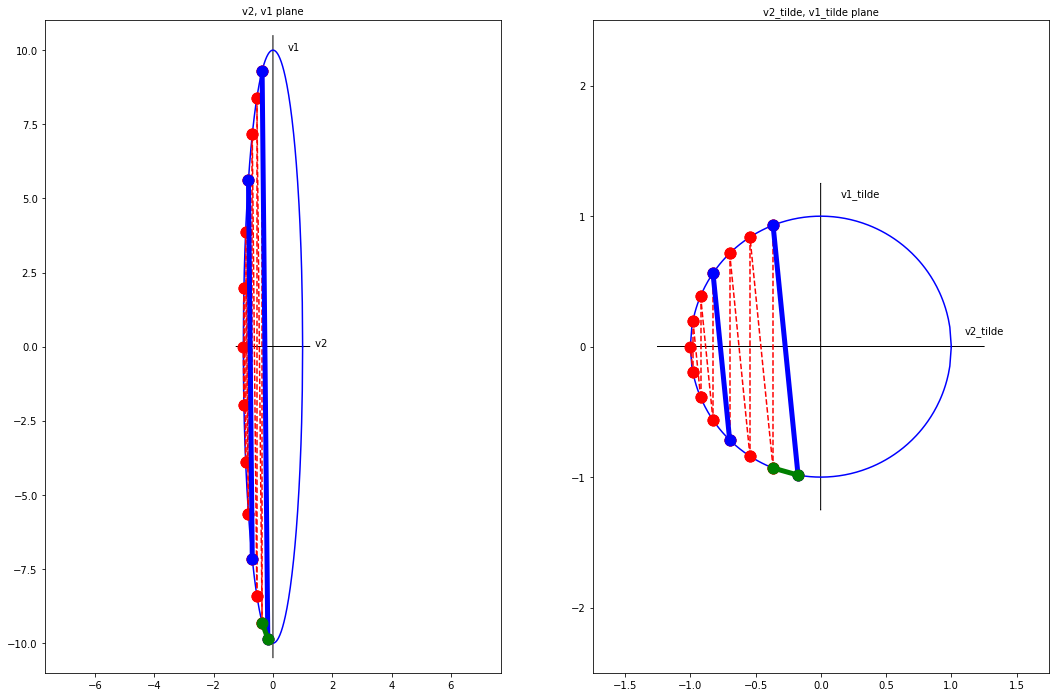

In [26]:
distance, distance_tilde = sim.adjacent_point_distance()
print("The distance between the two most recent adjacent points in (v2, v1) space is: " + str(distance) + "\n\n"\
      "The distance between the two most recent adjacent points in (v2_tilde, v1_tilde) space is: " + str(distance_tilde))
sim.fig

### The last claim we made is that the angle swept between two adjacent points (with respect to the origin) is constant. You probably already have a good feeling that this might be true from the above helper functions, but this last helper function will calculate the angle for us!

The angle between the two most recent adjacent points in (v2, v1) space is: [1.2371434]

The angle between the two most recent adjacent points in (v2_tilde, v1_tilde) space is: [11.42118627]


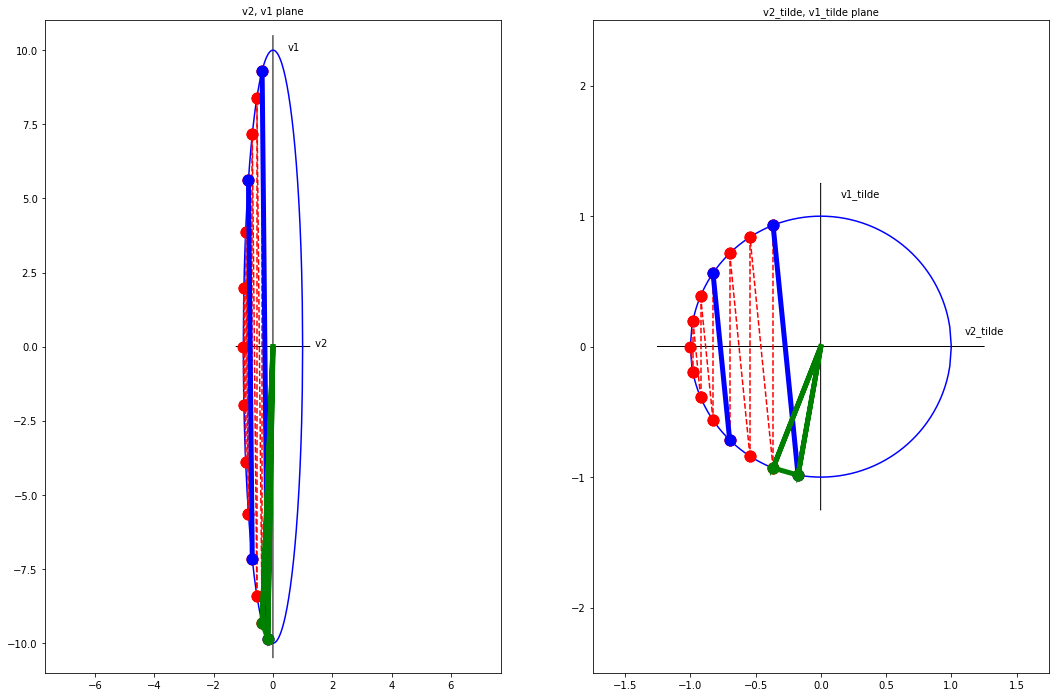

In [27]:
angle, angle_tilde = sim.adjacent_point_angle()
print("The angle between the two most recent adjacent points in (v2, v1) space is: " + str(angle) + "\n\n"\
      "The angle between the two most recent adjacent points in (v2_tilde, v1_tilde) space is: " + str(angle_tilde))
sim.fig

### Pretty cool right! We won't write the mathematical proof here (when my friend completes the write-up we'll put a link here to the document (in his DropBox or mine)). As a teaser, now that you know the angles are identical between adjacent points, the question becomes "how many times can we sweep this angle before the collisions end?" (for m2>>m1, this happens in a special region in the first quadrant). 

## There you have it! This Notebook was brought to you by Alex Augenstein and Rich Sofranko. Rich is finishing the write-up on our mathematical proof. I'll either re-create the results below or link to it in a public DropBox (or similar). Thanks for reading!